# Pretraining
Pretrains the network for the ReverberatorEstimator notebook with given parameters.
These parameters are estimated by listening to the target audio and doing a quick and rough tuning.

In [1]:
import matplotlib.pyplot as plt
import IPython
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras as tfk
from pedalboard import load_plugin
from ReverberatorEstimator import layers, models, config, utils
import warnings
warnings.filterwarnings('ignore')
import time

2.6.1


In [2]:
k = config.k
sample_rate = k['sample_rate']
sample_length = k['sample_length']
num_epochs = 5000
num_processors = k['n_processors']
steps_per_epoch = 1
batch_size = 1
epsilon = k['epsilon']
learning_rate = k['learning_rate']
dry_audio_path = k['dry_audio_path']
wet_audio_path = k['wet_audio_path']
vst_path = k['vst_path']
time_loss_weight = k['time_loss_weight']
spectral_loss_weight = k['spectral_loss_weight']
envelope_loss_weight = k['envelope_loss_weight']
echo_density_loss_weight = k['echo_density_loss_weight']
num_params = k['n_parameters']
parameter_map = k['parameter_map']
non_trainable_parameters = k['non_trainable_parameters']
pretrained_weights = k['pretrained_weights']

In [3]:
vst = load_plugin(vst_path)

In [4]:
x_train, y_train = utils.get_dataset(dry_audio_path, wet_audio_path, batch_size, resample=True, old_sample_rate=48000, new_sample_rate=sample_rate)

In [5]:
## HallOfFame estimation
target_parameters_list = [0.5, 0.9, 0.9]
attenuation_gain_params = [0.85, 0.88, 0.91, 0.87, 0.68, 0.51, 0.26, 0.13, 0.07, 0.07]
tonal_gain_params = [0.83, 0.81, 0.81, 0.81, 0.81, 0.75, 0.63, 0.53, 0.48, 0.41]
bc_gains = [0.65, 0.65]

target_parameters_list = target_parameters_list + attenuation_gain_params + tonal_gain_params
for i in range(16):
    target_parameters_list = target_parameters_list + bc_gains

target_parameters = tf.convert_to_tensor(target_parameters_list, dtype=tf.float32)
target_parameters = tf.reshape(target_parameters, [1, num_params])

In [6]:
model, parameter_model, _ = models.get_models(sample_length, sample_rate, num_params, 1, 
                                                vst_path, epsilon, parameter_map, non_trainable_parameters)


optimizer = tfk.optimizers.Adam(learning_rate=0.001) 
parameter_model.compile(optimizer=optimizer, loss='mae', run_eagerly=True)

input shape: (None, 96000)


In [7]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                              factor=0.2,
                              patience=100,
                              cooldown=1,
                              verbose=1,
                              mode='auto',
                              min_lr=0.000001)

In [8]:
start_time = time.time()
history = parameter_model.fit(x_train, target_parameters, verbose=1, epochs=num_epochs, batch_size=batch_size,
         callbacks=[lr_callback])
print("Training took %d seconds" % (time.time() - start_time))

Epoch 1/5000
1/1 [==============================] - 10s 10s/step - loss: 0.2128
Epoch 2/5000
1/1 [==============================] - 0s 37ms/step - loss: 0.1722
Epoch 3/5000
1/1 [==============================] - 0s 36ms/step - loss: 0.0892
Epoch 4/5000
1/1 [==============================] - 0s 37ms/step - loss: 0.0994
Epoch 5/5000
1/1 [==============================] - 0s 36ms/step - loss: 0.0272
Epoch 6/5000
1/1 [==============================] - 0s 36ms/step - loss: 0.0096
Epoch 7/5000
1/1 [==============================] - 0s 38ms/step - loss: 0.0096
Epoch 8/5000
1/1 [==============================] - 0s 36ms/step - loss: 0.0095
Epoch 9/5000
1/1 [==============================] - 0s 37ms/step - loss: 0.0095
Epoch 10/5000
1/1 [==============================] - 0s 35ms/step - loss: 0.0094
Epoch 11/5000
1/1 [==============================] - 0s 38ms/step - loss: 0.0094
Epoch 12/5000
1/1 [==============================] - 0s 36ms/step - loss: 0.0112
Epoch 13/5000
1/1 [==================

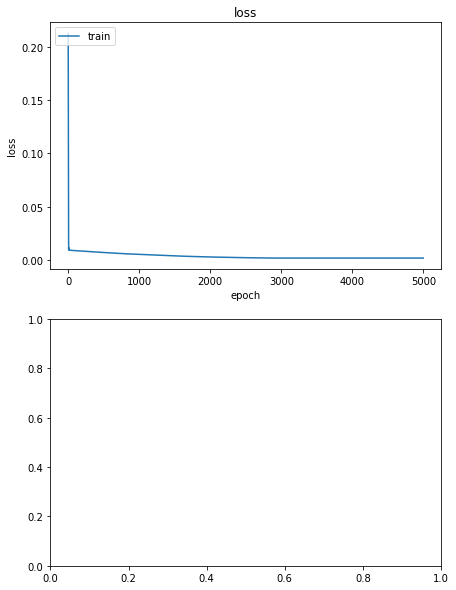

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,10))
ax[0].plot(history.history['loss'])
ax[0].set_title('loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

In [10]:
parameters = parameter_model(tf.reshape(x_train[0], (1, sample_length)))

In [11]:
params = parameters.numpy()[0]
print(params)

[0.5        0.5        0.09258156 0.49999988 0.49999994 0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.49999994 0.49999994 0.49999994 0.49999994
 0.5        0.5        0.5        0.5        0.5        0.50000006
 0.5        0.5        0.5        0.5        0.5        0.5
 0.50000006 0.5        0.5        0.5        0.5        0.49999994
 0.5        0.50000006 0.5        0.5        0.5        0.5
 0.50000006 0.5        0.5        0.49999994 0.5        0.5
 0.5        0.5        0.49999994 0.5        0.5        0.5
 0.5       ]


(-1.0, 1.0)

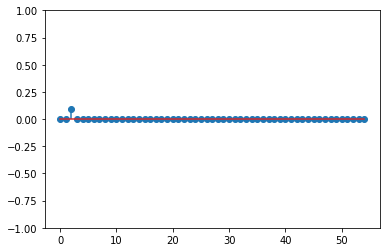

In [12]:
param_diff = params - target_parameters_list
plt.stem(param_diff)
plt.ylim([-1, 1])

In [13]:
parameter_model.save_weights(pretrained_weights)

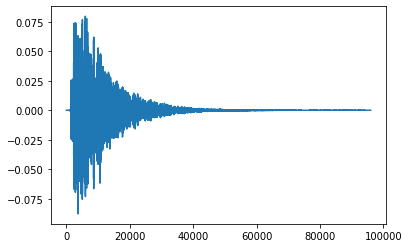

In [14]:
for i in range(len(params)):
    parameter_idx = parameter_map[i]
    parameter_value = params[i]
    layers.set_parameter(vst, parameter_idx, parameter_value)
output = vst.process(x_train[0], sample_rate)
IPython.display.display(IPython.display.Audio(output, rate=sample_rate))
plt.plot(output)